## Introduction
This creates a model for pickling that can then be used by Osprey 


In [1]:
from glob import glob
import mdtraj as md
import pickle
import numpy as np
from scipy.stats import circstd, circmean
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = '/Users/robert_arbon/Google Drive/Research/AADH/Analysis/Data/proc_traj'
traj_paths = glob(data_dir+'/2agy-*-as*.nc')
print(len(traj_paths))

200


In [3]:
trajs = [md.load(traj_path, top=data_dir+'/2agy-as1.prmtop', stride=20) for traj_path in traj_paths]

## Dihedrals

In [4]:
idxs = pickle.load(open(data_dir+'/2agy_as-1_dihedrals.pickl', 'rb'))

In [5]:
dihed_idx = []
for idx in idxs:
    if not idx in dihed_idx:
        dihed_idx.append(idx)
        

In [6]:
dihedrals = [md.compute_dihedrals(traj, dihed_idx) for traj in trajs]

In [7]:
dxx = np.concatenate(dihedrals)

In [8]:
dihed_std = circstd(dxx, np.pi, -np.pi, axis=0)
dihed_mean = circmean(dxx, np.pi, -np.pi, axis=0)

<Container object of 3 artists>

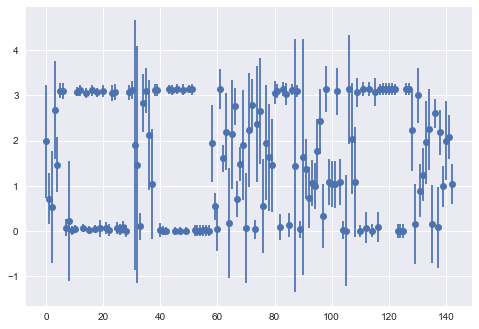

In [9]:
plt.errorbar(x=np.arange(dxx.shape[1]), y=np.abs(dihed_mean[:,]), yerr=dihed_std, fmt='o')

<Container object of 143 artists>

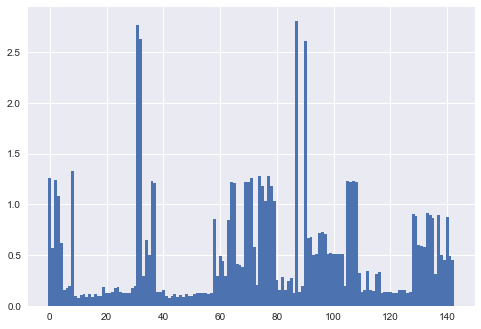

In [10]:
plt.bar(np.arange(dihed_std.shape[0]), dihed_std, width=1)

[0.078297034, 0.72808528, 2.8050547]


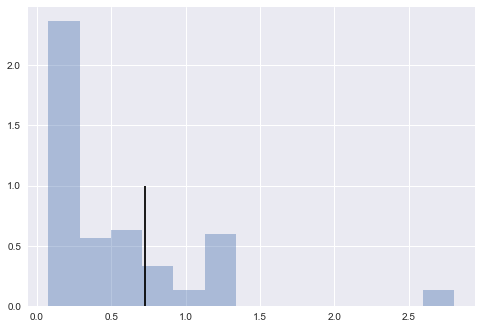

In [11]:
import jenks
cuts = jenks.jenks(dihed_std, 2)
print(cuts)
g = sns.distplot(dihed_std, kde=False, norm_hist=True)
g.axes.vlines(cuts[1], 0, 1)

### Select high variance features
Let's keep those above the middle cut. 

In [12]:
dihed_cut = cuts[1]
dihed_high_var = np.where(dihed_std>dihed_cut)[0]
dihed_high_var_idx = [dihed_idx[i] for i in dihed_high_var]

In [13]:
traj = trajs[0][0]

In [14]:
import nglview as nv

view = nv.show_mdtraj(traj)
view.add_line()
for i, idxs in enumerate(dihed_high_var_idx):
    view.add_representation(repr_type='hyperball', selection=list(idxs))
view

In [15]:
len(dihed_high_var_idx)

np.save( '../Common/high_variance_dihedrals_active_site.npy', np.array(dihed_high_var_idx))

## Angles

In [16]:
idxs = pickle.load(open(data_dir+'/2agy_as-1_angles.pickl', 'rb'))
angle_idx = []
for idx in idxs:
    if not idx in angle_idx:
        angle_idx.append(idx)

In [17]:
angles = [md.compute_angles(traj, angle_idx) for traj in trajs]

In [18]:
axx = np.concatenate(angles)

In [19]:
angle_std = circstd(axx, 2*np.pi, 0, axis=0)
angle_mean = circmean(axx, 2*np.pi, 0, axis=0)

<Container object of 3 artists>

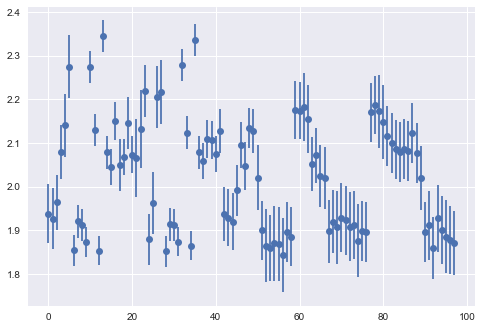

In [20]:
plt.errorbar(x=np.arange(axx.shape[1]), y=np.abs(angle_mean[:,]), yerr=angle_std, fmt='o')

<Container object of 98 artists>

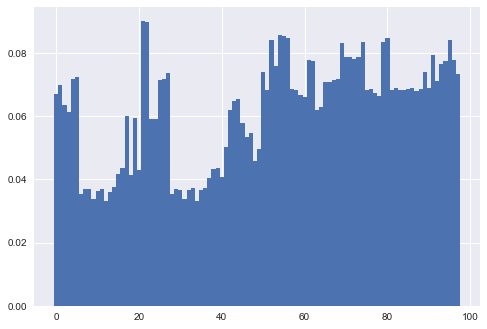

In [21]:
plt.bar(np.arange(angle_std.shape[0]), angle_std, width=1)

[0.032991491, 0.054591086, 0.089981169]


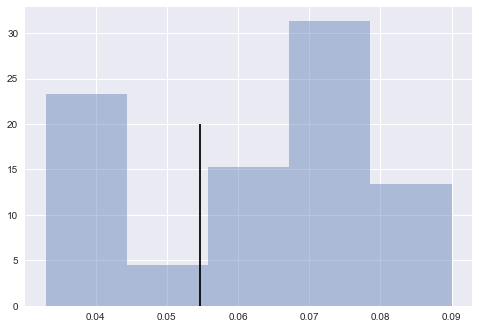

In [22]:
cuts = jenks.jenks(angle_std, 2)
print(cuts)
g = sns.distplot(angle_std, kde=False, norm_hist=True)
g.axes.vlines(cuts[1], 0, 20)


In [23]:
angle_cut = cuts[1]
angle_high_var = np.where(angle_std>angle_cut)[0]
angle_high_var_idx = [angle_idx[i] for i in angle_high_var]

In [24]:
np.save( '../Common/high_variance_angles_active_site.npy', np.array(angle_high_var_idx))

## Interatomic distances


In [25]:
heavy_atoms = trajs[0].top.select("element != H")

In [26]:
len(heavy_atoms)

35

In [27]:
df, _ = trajs[0].top.to_dataframe()

In [29]:
import itertools
pairs = []
for x, y in itertools.combinations(heavy_atoms, 2):
    pairs.append([x,y])
pairs = np.array(pairs)

In [30]:
distances = [md.compute_distances(traj, atom_pairs = pairs) for traj in trajs]

In [31]:
dixx = np.concatenate(distances)

In [32]:
distances_std = np.std(dixx, axis=0)

<Container object of 595 artists>

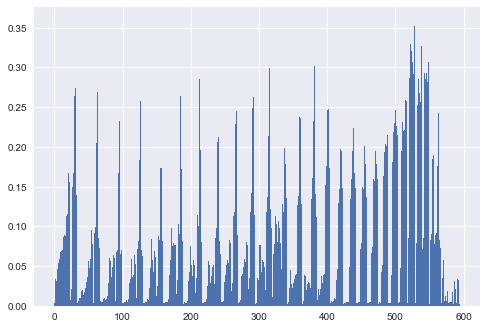

In [33]:
plt.bar(np.arange(distances_std.shape[0]), distances_std, width=1)

In [34]:
cuts = jenks.jenks(distances_std, 2)
cuts

[0.0022875452, 0.12647815, 0.35842377]

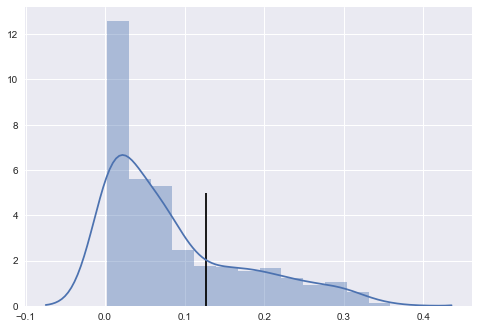

In [35]:
sns.distplot(distances_std)
plt.vlines(cuts[-2], 0, 5)

In [36]:
dist_cut = cuts[-2]
dist_high_var = np.where(distances_std>dist_cut)[0]
dist_high_var_idx = [pairs[i] for i in dist_high_var]

In [37]:
len(dist_high_var_idx)

155

In [39]:
_, bonds = traj.top.to_dataframe()

In [ ]:
traj.top.atoms

In [44]:
for x, y in dist_high_var_idx:
    traj.top.add_bond(traj.top.atom(x),traj.top.atom(y))

In [47]:
import nglview as nv
view = nv.show_mdtraj(traj)
for i, idxs in enumerate(bonds):
    view.add_representation(repr_type='hyperball', selection=list(idxs))
# sns_color_palette = sns.cubehelix_palette(6).as_hex()
# colors = [c.replace('#', '0x') for c in sns_color_palette]
for i, idxs in enumerate(dist_high_var_idx):
    view.add_representation(repr_type='line', selection=list(idxs))
view

In [48]:
np.save( '../Common/high_variance_distances_active_site.npy', np.array(dist_high_var_idx))